# Country Data ~ GLMMIX


---
```
: Zach Wolpe
: zach.wolpe@medibio.com.au
: 2023-05-19
```

In [1]:
from modules.bayesian_model_generator   import *
from modules.bayesian_model_interface   import *
from modules.probabilistic_inference    import *
from modules.Frequentist_Models         import *
from modules.dependencies               import *
from modules.cMDE_models                import *
from modules.filter_data                import *
from modules.load_data                  import *
from modules.helpers                    import *

/Users/zachwolpe/miniforge3/envs/pyrojax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CD = CountriesData()

# summary stats
CD.correlations()
CD.countries.groupby('Region_Encode').agg({
    'GDP ($ per capita)': 'mean',
    'Literacy (%)': 'mean',

}).reset_index().corr()

,Region_Encode,GDP ($ per capita),Literacy (%)
Region_Encode,1.000000,0.257287,0.346017
GDP ($ per capita),0.257287,1.000000,0.544380
Literacy (%),0.346017,0.544380,1.000000


In [4]:
CountryPlots.violin(CD.countries).show()
CountryPlots.scatter(CD.countries).show()
CountryPlots.scatter_3d(CD.countries).show()

---
# Cluster
---

Perhaps we can find more meaningful groups by clustering the data - focusing on variance maximisizing and not (semi-arbitrary) geographic boundaries.

In [5]:
# KPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# scale
scaler = StandardScaler()
kpca   = KernelPCA(n_components=2, kernel='rbf', gamma=0.1)
kmeans = KMeans(n_clusters=3, random_state=1)
pipe   = Pipeline([('scaler', scaler), ('kpca', kpca), ('kmeans', kmeans)])


# fit
cntry = CD.countries.dropna()
pipe.fit(cntry.iloc[:,2:])
cntry['Cluster']  = pipe.predict(cntry.iloc[:,2:])
cntry['Cluster']  = cntry['Cluster'].astype(int)
cntry['Cluster2'] = cntry['Cluster'].astype(str)

In [6]:

CountryPlots.violin(cntry, color='Cluster', x='Cluster').show()
CountryPlots.scatter(cntry, color='Cluster2', log_x=True, log_y=True).show()
CountryPlots.scatter_3d(cntry, color='Cluster2', log_x=True).show()

----
# Model
---

In [7]:
# params
class params:
    num_warmup      = 1000
    num_samples     = 2000
    num_chains      = 2
    disable_progbar = False



# Vars
X_vars  = ['Phones (per 1000)', 'Birthrate']
X_vars  = ['Phones (per 1000)']
y_var   = 'GDP ($ per capita)'
grp_var = 'Cluster'

# Data Generator
fd = FilterData(cntry, X_vars, y_var, group_var=grp_var).train_test_split()

In [8]:
# suppress warnings
warnings.filterwarnings('ignore')


In [9]:
FM = FrequentistModels(fd.X_training, fd.y_training, fd.X_testing, fd.y_testing, model_name='Linear Regression').fit().predict().print_score().print_model()
FM.plot_model(fd).show()

R^2:  0.7020341467535611
LinearRegression()


In [10]:

bm = FrequentistModels(fd.X_training, fd.y_training, fd.X_testing, fd.y_testing, model_name='Linear GAM').fit().predict().print_score().print_model()
bm.plot_model(fd, c='#EE4B2B', c2='#1434A4').show()

R^2:  0.7410190959250406
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.5162
Link Function:                     IdentityLink Log Likelihood:                                 -2102.8845
Number of Samples:                          119 AIC:                                             4226.8014
                                                AICc:                                            4229.0549
                                                GCV:                                         21998375.7652
                                                Scale:                                       18856345.5069
                                                Pseudo R-Squared:                                   0.8281
Feature Func

---
# FIT PYRO
----


### Fit 1: Select Grouping Proc

In [11]:
# Model Set
Fit_1 = dict(
    Inference_Engine    = BayesianModelEngine(),
    params              = params,
    y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group              = fd.to_jax(fd.group_training),
    Group_Technique    = 'PartiallyPooled',
)

Fit_2 = dict(
    Inference_Engine    = BayesianModelEngine(),
    params              = params,
    y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group              = fd.to_jax(fd.group_training),
    Group_Technique    = 'FullyPooled',
)

Fit_3 = dict(
    Inference_Engine    = BayesianModelEngine(),
    params              = params,
    y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group              = fd.to_jax(fd.group_training),
    Group_Technique    = 'Unpooled',
)


BM = []
for F in [Fit_1, Fit_2, Fit_3]:
    Probabilistic_Inference.run_inference(**F)
    BM.append(F['Inference_Engine'])

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2118.26it/s, 3 steps of size 7.55e-01. acc. prob=0.88]


In [12]:
# get memory location
def check_BM_cycled(): 
    locs = []
    for b in BM:
        assert id(b) not in locs, 'Bayesian Model has been cycled.'
    print('PASSED: Model has not been cycled.')


check_BM_cycled()

PASSED: Model has not been cycled.


In [13]:
def compare_models(BM):
    check_BM_cycled()
    compare_dict = {f'model {i}':az.from_numpyro(b.mcmc) for i,b in enumerate(BM)}
    return az.compare(compare_dict, method='pseudo-BMA', ic='waic')


compare_models(BM)

PASSED: Model has not been cycled.


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model 0,0,-148034.769768,9.447089,0.000000,1.0,216.963531,0.000000,False,log
model 1,1,-154519.555788,3.172811,6484.786020,0.0,176.212098,151.260588,False,log
model 2,2,-154520.224276,3.253650,6485.454508,0.0,176.209720,151.256315,False,log


### Fit 2. Grand Intecept

In [14]:
Fit_1 = dict(
    Inference_Engine    = BayesianModelEngine(),
    params              = params,
    y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group               = fd.to_jax(fd.group_training),
    Group_Technique     = 'PartiallyPooled',
    Intercept           = True
)

Fit_2 = dict(
    Inference_Engine    = BayesianModelEngine(),
    params              = params,
    y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group               = fd.to_jax(fd.group_training),
    Group_Technique     = 'PartiallyPooled',
)


BM = []
for F in [Fit_1, Fit_2]:
    Probabilistic_Inference.run_inference(**F)
    BM.append(F['Inference_Engine'])

compare_models(BM)

sample: 100%|██████████| 3000/3000 [00:04<00:00, 685.53it/s, 7 steps of size 5.25e-01. acc. prob=0.92] 


PASSED: Model has not been cycled.


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model 0,0,-148034.555961,9.365771,0.000000,0.553249,216.931331,0.000000,False,log
model 1,1,-148034.769768,9.447089,0.213807,0.446751,216.963531,0.058975,False,log


### Fit 3. Check for Random Slope

In [15]:
Fit_1 = dict(
    Inference_Engine    = BayesianModelEngine(),
    params              = params,
    y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group               = fd.to_jax(fd.group_training),
    Group_Technique     = 'PartiallyPooled',
    Intercept           = True
)

Fit_2 = dict(
    Inference_Engine    = BayesianModelEngine(),
    params              = params,
    y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group               = fd.to_jax(fd.group_training),
    Group_Technique     = 'PartiallyPooled',
    Intercept           = True,
    RandSlopeVar        = 'X1'
)


BM = []
for F in [Fit_1, Fit_2]:
    Probabilistic_Inference.run_inference(**F)
    BM.append(F['Inference_Engine'])

compare_models(BM)

sample: 100%|██████████| 3000/3000 [00:15<00:00, 197.28it/s, 15 steps of size 2.25e-01. acc. prob=0.79]


PASSED: Model has not been cycled.


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model 0,0,-148034.555961,9.365771,0.000000,1.000000e+00,216.931331,0.000000,False,log
model 1,1,-148168.409457,12.255474,133.853497,7.381847e-59,216.135530,21.137579,False,log


### Fit 4. Select Intercept Proc

In [16]:
Bayes = BM[0]
F = Fit_1

predictive  = Predictive(Bayes.model, Bayes.mcmc.get_samples())
predictions = predictive(jax.random.PRNGKey(43), 

    # y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group               = fd.to_jax(fd.group_training),
    Group_Technique     = 'PartiallyPooled',
    Intercept           = True

    )

predictions['obs'].shape

(4000, 119, 119)

In [17]:

yhat =predictions['obs'].mean(axis=0).mean(axis=0)

results = pd.DataFrame({'x':F['X1'].reshape(-1,), 'y':F['y'], 'Group':F['Group']})
results['yhat'] = yhat
results = results.sort_values('x')
results.corr()

,x,y,Group,yhat
x,1.000000,0.898835,0.590120,0.608598
y,0.898835,1.000000,0.543396,0.617537
Group,0.590120,0.543396,1.000000,0.881411
yhat,0.608598,0.617537,0.881411,1.000000


In [18]:
predictive  = Predictive(Bayes.model, Bayes.mcmc.get_samples())
predictions = predictive(jax.random.PRNGKey(43), 

    # y                   = fd.to_jax(fd.y_training),
    X1                  = fd.to_jax(fd.X_training.astype(float)),
    Group               = fd.to_jax(fd.group_training),
    Group_Technique     = 'PartiallyPooled',
    Intercept           = True

    )

predictions['obs'].shape

(4000, 119, 119)

----
# Posterior Analysis
----



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    Beta[0]      3.15      0.22      3.15      2.80      3.52   3936.14      1.00
  intercept      0.01      0.20      0.01     -0.31      0.33   6219.80      1.00
       mu_a      7.36      5.07      7.33     -1.03     15.55   6147.08      1.00
rand_int[0]   4693.74     94.29   4694.80   4537.64   4846.78   4671.82      1.00
rand_int[1]   6090.00    100.98   6090.75   5927.75   6260.37   5219.97      1.00
rand_int[2]  18147.17    132.58  18147.78  17937.76  18374.65   3926.91      1.00
       sg_a    313.80      2.71    313.82    309.29    318.24   5327.48      1.00
      sigma   6635.14     31.36   6634.95   6583.51   6687.43   7022.93      1.00

Number of divergences: 0


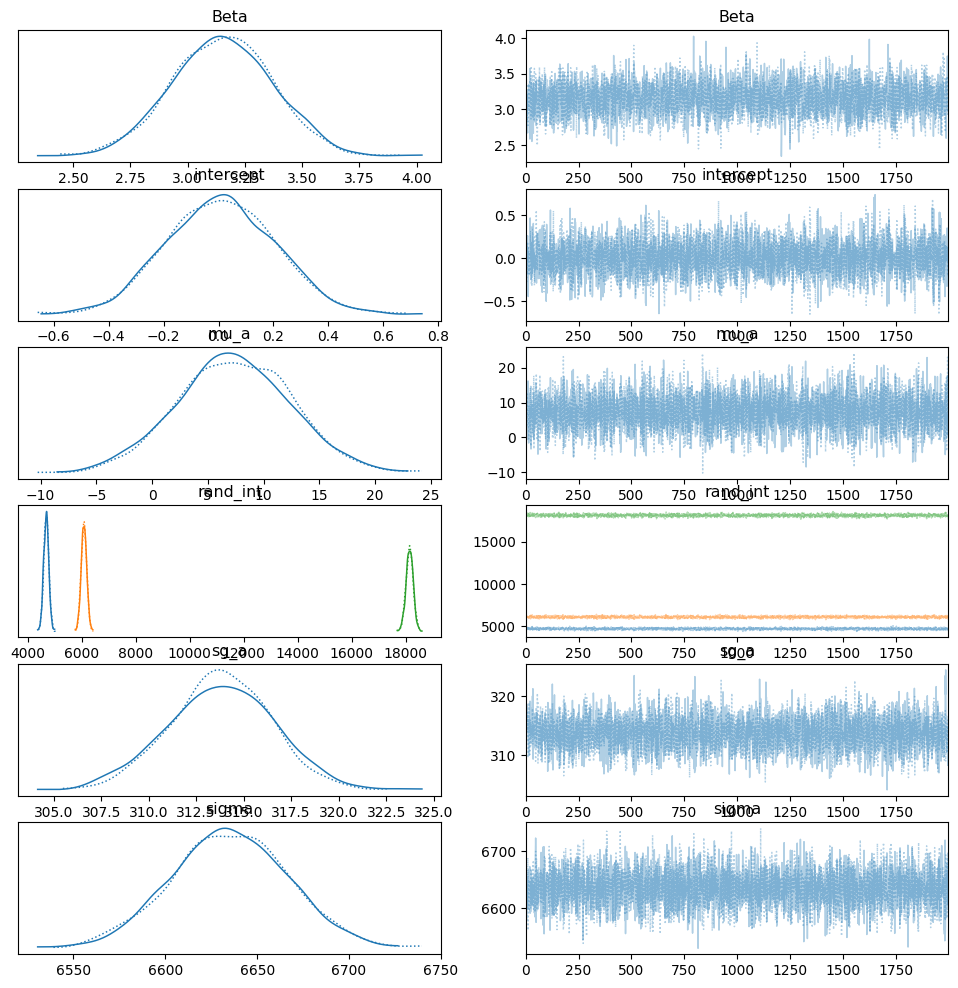

In [24]:
final_model = BM[0]
final_model.print_summary()
final_model.plot_trace()

In [25]:
# Plot posteriors
samples = final_model.mcmc.get_samples()
samples.keys()

dict_keys(['Beta', 'intercept', 'mu_a', 'rand_int', 'sg_a', 'sigma'])

In [75]:
n   =  samples['rand_int'].shape[1]
cls = 'steelblue','darkred','cyan'
cls = ['#F8B195', '#c06c84', '#355C7D', '#6C5B7B','cyan'] # '#c06c84',

# import make subplots module
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=n)
for c,clr in zip(range(1,n+1), cls):
    for r in [1,2]:  
        if r == 1:
            fig.add_trace(go.Histogram(x=samples['rand_int'][:,c-1], showlegend=False, marker_color=clr), row=r, col=c)
            # add kde plot
            

            # fig.add_trace(go.Histogram(x=samples['rand_int'][:,c-1], showlegend=False,), row=r, col=c)
        else:
            fig.add_trace(go.Scatter(y=samples['rand_int'][:,c-1], showlegend=False, marker_color=clr), row=r, col=c)

fig.update_layout(template='none', title='Cluster Posteriors')
fig.show()

In [48]:
dfx = pd.DataFrame(samples['rand_int'])
dfx.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3']

# kde plot

from plotly import figure_factory as ff
fig = ff.create_distplot([dfx[c] for c in dfx.columns], dfx.columns, show_hist=False, show_rug=False)
fig.show()